In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import load_dataset

svhn = load_dataset("svhn", "full_numbers")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/33402 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/13068 [00:00<?, ? examples/s]

Generating extra split:   0%|          | 0/202353 [00:00<?, ? examples/s]

In [ ]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def change_values(tensor, original, new):
    tensor[tensor == original] = new
    return tensor

In [ ]:
from torch import Tensor
from torch.utils.data import Dataset
from torchvision.ops.boxes import box_convert
from torchvision.transforms import functional as F

class CustomDataset(Dataset):
    def __init__(self, original_dataset):
        self.images = original_dataset["image"]
        self.targets = original_dataset["digits"]
        # self.transform = transforms.Compose([
        #     # transforms.Resize((224, 224)),
        #     transforms.ToTensor()
        # ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = F.to_tensor(image).to(device)

        target = self.targets[idx]

        boxes = box_convert(Tensor(target["bbox"]), "xywh", "xyxy").to(device)

        labels = change_values(Tensor(target["label"]).long(), 0, 10).to(device)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        return image, target

train_dataset = CustomDataset(svhn["train"])
test_dataset = CustomDataset(svhn["test"])

In [ ]:
from torch.utils.data import DataLoader

collate_fn = lambda x: tuple(zip(*x))

train_data_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=6, shuffle=False, collate_fn=collate_fn)

In [ ]:
import torchvision
import torchvision.models.detection as models
from torchvision.transforms import transforms

model = torchvision.models.detection.fasterrcnn_resnet50_fpn().to(device)

num_classes = 11
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.faster_rcnn.FastRCNNPredictor(in_features, num_classes).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.5MB/s]


In [ ]:
#@title MobileNet (Commented Out)
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),),
#     aspect_ratios=((0.5, 1.0, 2.0),)
# )

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0', '1', '2', '3'],
#     output_size=7,
#     sampling_ratio=2
# )

# # put the pieces together inside a Faster-RCNN model
# model = FasterRCNN(
#     backbone,
#     num_classes=num_classes,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# ).to(device)

In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.0025,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.5
)

In [ ]:
epoch_losses = []

In [ ]:
first_epoch_num = 1
last_epoch_num = 4

In [ ]:
from tqdm import tqdm

for epoch in range(first_epoch_num, last_epoch_num + 1):
    model.train()

    epoch_loss = 0

    for images, targets in tqdm(train_data_loader):
        # images = [Tensor(image).to(device) for image in images]
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # print(images[0].device)
        # print(list(targets[0].values())[0].device)

        loss_dict = model(images, targets)

        # Backpropagation
        losses = sum(loss_dict.values())
        epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Update learning rate
    # lr_scheduler.step()

    # # Evaluation
    # model.eval()
    # with torch.no_grad():
    #     total_loss = 0.0
    #     for images, targets in tqdm(test_data_loader, leave=False):
    #         # images = list(image.to(device) for image in images)
    #         # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    #         # Forward pass
    #         loss_dict, detections = eval_forward(model, images, targets)

    #         # Calculate total loss
    #         losses = sum(loss for loss in loss_dict.values())
    #         total_loss += losses.item()

    #     # Calculate average loss
    #     average_loss = total_loss / len(test_data_loader)

    #     losses_over_time.append(average_loss)

    #     # Print evaluation metrics
    epoch_losses.append(epoch_loss)
    print(f"Epoch [{epoch}/{last_epoch_num}], Loss: {epoch_loss:.4f}")

100%|██████████| 5567/5567 [2:26:00<00:00,  1.57s/it]

Epoch [3/3], Loss: 1295.8288


<Figure size 640x480 with 0 Axes>

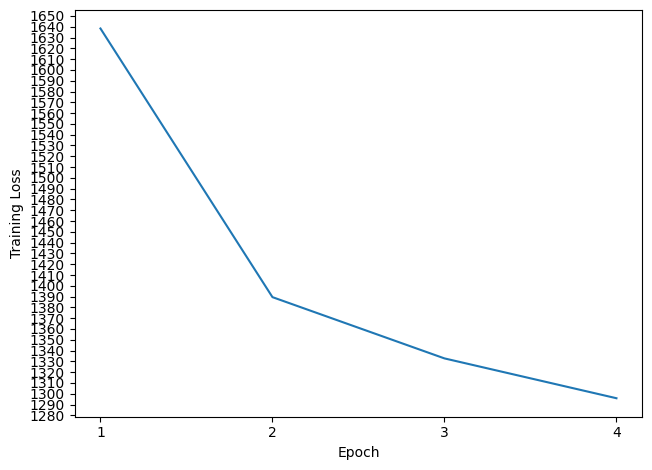

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # Set labels for axes
    ax.set_xlabel('Epoch')  # Label for bottom axis
    ax.set_ylabel('Training Loss')  # Label for left axis
    # Adjust x-axis range
    ax.set_xticks(range(1, last_epoch_num + 1))
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=10)
    ax.yaxis.set_major_locator(loc)

    # Shifting the x-coordinates of points to the right by one unit
    shifted_points = [(i + 1, y) for i, y in enumerate(points)]

    # Unpacking the shifted points into separate lists of x and y coordinates
    x, y = zip(*shifted_points)

    plt.tight_layout()

    plt.plot(x, y)

showPlot(epoch_losses)

In [ ]:
# See https://huggingface.co/datasets/svhn/viewer/full_numbers/test

index = 3

test_iter = iter(test_data_loader)
for _ in range(index//6 + 1):
    current = next(test_iter)

index %= 6

image = current[0][index]
labels = current[1][index]

model.eval()
with torch.no_grad():
    prediction = model([image])[0]

change_values(prediction["labels"], 10, 0)

selected_indices = torch.where(prediction["scores"] >= 0.8)[0]
prediction = {key: tensor[selected_indices] for key, tensor in prediction.items()}

non_overlapping_indices = torchvision.ops.nms(prediction["boxes"], prediction["scores"], 0.4)
prediction = {key: tensor[non_overlapping_indices] for key, tensor in prediction.items()}

sorted_indices = sorted(range(len(prediction["labels"])), key=lambda i: prediction["boxes"][i][0])
prediction = {key: tensor[sorted_indices] for key, tensor in prediction.items()}

print(prediction)

{'boxes': tensor([[35.6490,  7.8379, 47.9001, 30.3143],
        [46.6362,  8.9590, 57.1780, 28.4368],
        [55.9995,  8.7633, 67.9608, 28.7896]], device='cuda:0'), 'labels': tensor([6, 4, 9], device='cuda:0'), 'scores': tensor([0.9177, 0.9948, 0.9674], device='cuda:0')}


In [ ]:
import matplotlib.pyplot as plt

from torchvision.io import read_image
from torchvision.transforms import v2 as T
from torchvision.utils import draw_bounding_boxes

eval_transform = T.Compose([T.ToDtype(torch.float, scale=True), T.ToPureTensor()])

def filter_and_sort_prediction(prediction):
    # Makes the operations faster since there won't be the overhead of making
    # calls to the GPU. This should be fine since the number of digits detected
    # in a single photo should be small.
    prediction = {key: tensor.cpu() for key, tensor in prediction.items()}

    change_values(prediction["labels"], 10, 0)

    selected_indices = torch.where(prediction["scores"] >= 0.7)[0]
    prediction = {key: tensor[selected_indices] for key, tensor in prediction.items()}

    non_overlapping_indices = torchvision.ops.nms(prediction["boxes"], prediction["scores"], 0.4)
    prediction = {key: tensor[non_overlapping_indices] for key, tensor in prediction.items()}

    sorted_indices = sorted(range(len(prediction["labels"])), key=lambda i: prediction["boxes"][i][0])
    prediction = {key: tensor[sorted_indices] for key, tensor in prediction.items()}

    return prediction

@torch.no_grad()
def find_digits(image_path):
    image = read_image(image_path)
    x = eval_transform(image)[:3, ...].to(device)

    model.eval()
    prediction = filter_and_sort_prediction(model([x])[0])

    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]
    pred_labels = [f"{label} : {score:.3f}" for label, score in zip(prediction["labels"], prediction["scores"])]
    pred_boxes = prediction["boxes"].long()
    output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

    print("Detected: " + "".join(map(str, prediction["labels"].tolist())))

    plt.figure(figsize=(12, 12))
    plt.imshow(output_image.permute(1, 2, 0))

Detected: 56


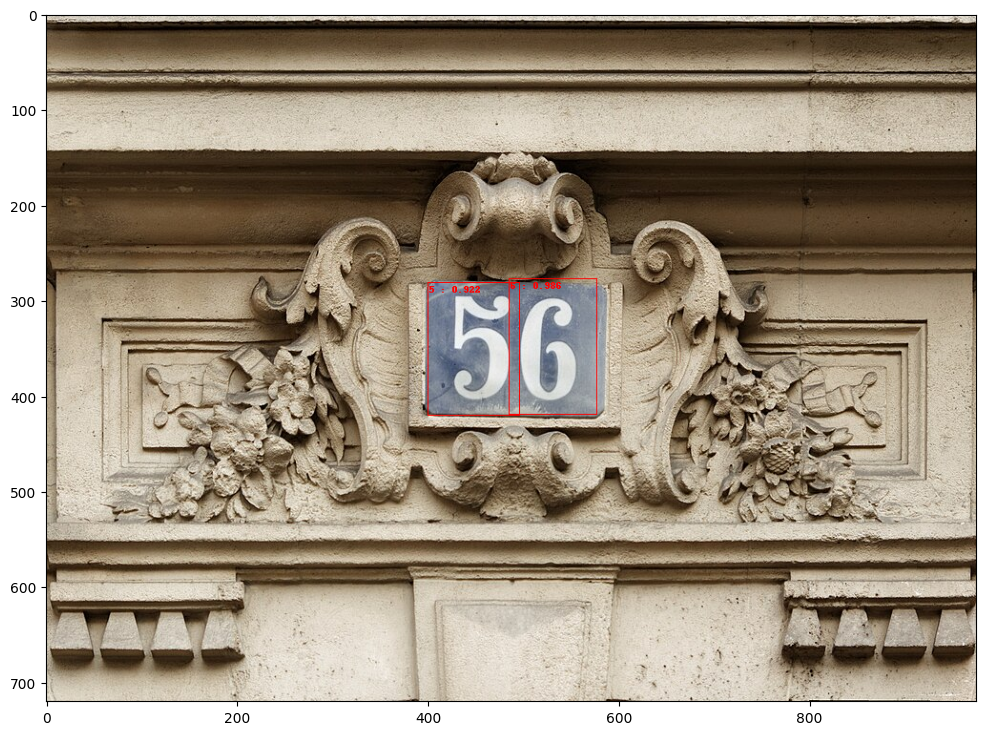

In [ ]:
# Image taken from https://commons.wikimedia.org/wiki/File:Boulevard_de_Magenta_(Paris),_num%C3%A9ro_56,_porte_02.jpg

find_digits("test.jpg")

Detected: 178


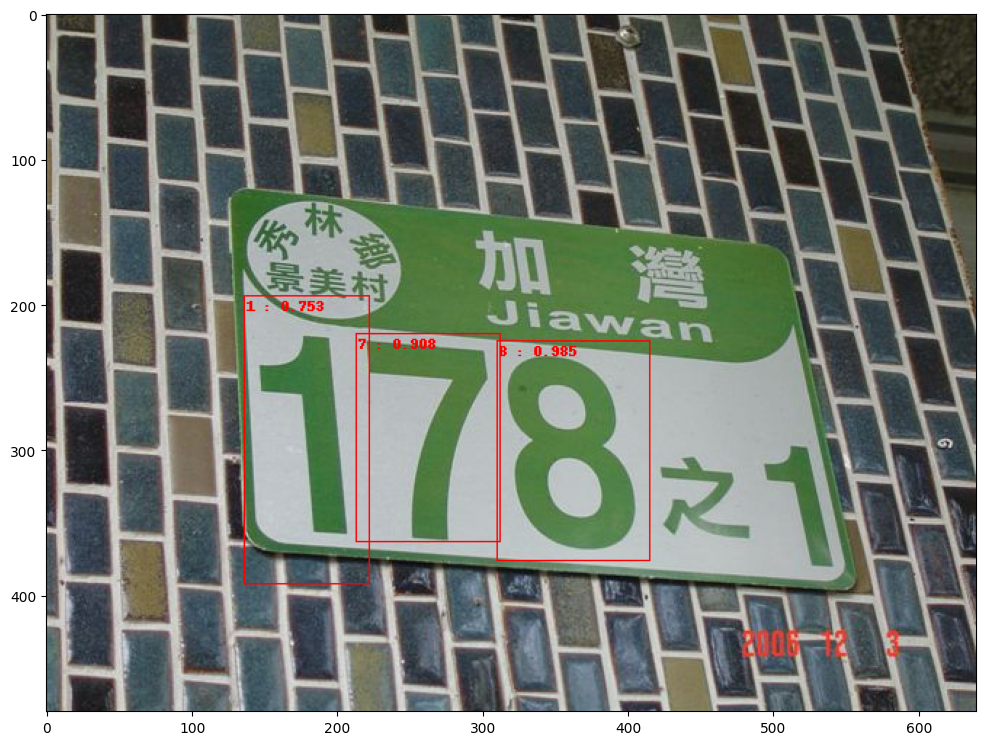

In [ ]:
# Image taken from https://commons.wikimedia.org/wiki/File:House_number_of_TRA_Jingmei_Station_20061203.jpg

find_digits("test2.jpg")

# Notice that the larger 1 was detected but not the smaller 1.